In [1]:
#un canale

In [2]:
from NewLibraryENG import *
from tqdm.notebook import tqdm
import sklearn.preprocessing as ps
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from random import randint
from fastdtw import fastdtw
import copy
import pymc as pm
name_data = '2018-11-27T10-29-42POP 2 BL .h5'
name_data2 = '2018-11-27T12-03-02POP 2 stimulation.h5'
name_data3='2018-11-27T10-56-39MiP5 KA stimulation.h5'
name_data4='2018-11-27T11-24-28MiP3 stimulation.h5'
name_data5='2018-11-27T10-40-53POP 3 BL .h5'
complete_string='/Users/Gaia_1/Downloads/PoiProMEA-master/h5files/'+name_data
complete_string2='/Users/Gaia_1/Downloads/PoiProMEA-master/h5files/'+name_data2
complete_string3='/Users/Gaia_1/Downloads/PoiProMEA-master/h5files/'+name_data3
complete_string4='/Users/Gaia_1/Downloads/PoiProMEA-master/h5files/'+name_data4
complete_string5='/Users/Gaia_1/Downloads/PoiProMEA-master/h5files/'+name_data5
name_data='2019-01-24T16-00-33Pop1 24hour after.h5'
name_data_st = '2019-01-23T16-06-32Pop1 healthy cortical .h5'
name_data_BL = '2019-01-23T11-19-05PoP1 healthy cortical .h5'
name_data_24 = '2019-01-24T16-00-33Pop1 24hour after.h5'

complete_string='/Users/Gaia_1/Desktop/allh5files/healthy/healthy_baseline/'+name_data_BL
#complete_string='/Users/Gaia_1/Desktop/allh5files/healthy/healthy_stimulation/'+name_data_st
#complete_string='/Users/Gaia_1/Desktop/allh5files/healthy/healthy 24hrs later/'+name_data_24

In [3]:
data = h5py.File(complete_string,'r')
#data = h5py.File(complete_string2,'r')
#data = h5py.File(complete_string3,'r')
#data = h5py.File(complete_string4,'r') #Stimulated
#data = h5py.File(complete_string5,'r') #BL

data_readings = data['Data']['Recording_0']['AnalogStream']['Stream_0']['ChannelData'][()]
info = data['Data']['Recording_0']['AnalogStream']['Stream_0']['InfoChannel'][()]
info_table = pd.DataFrame(info, columns = list(info.dtype.fields.keys()))
labels = info_table['Label']
readings = pd.DataFrame(data = data_readings.transpose(), columns = labels)
fs = 10000 #Sampling Frequency
print(readings.shape)

(4222000, 60)


In [4]:
readings.columns

Index([ b'47',  b'48',  b'46',  b'45',  b'38',  b'37',  b'28',  b'36',  b'27',
        b'17',  b'26',  b'16',  b'35',  b'25', b'Ref',  b'14',  b'24',  b'34',
        b'13',  b'23',  b'12',  b'22',  b'33',  b'21',  b'32',  b'31',  b'44',
        b'43',  b'41',  b'42',  b'52',  b'51',  b'53',  b'54',  b'61',  b'62',
        b'71',  b'63',  b'72',  b'82',  b'73',  b'83',  b'64',  b'74',  b'84',
        b'85',  b'75',  b'65',  b'86',  b'76',  b'87',  b'77',  b'66',  b'78',
        b'67',  b'68',  b'55',  b'56',  b'58',  b'57'],
      dtype='object', name='Label')

In [5]:
inizio=0
len_data=180000 #192 secondi
len_data=len(readings)
prova_multi=readings.iloc[inizio:len_data, :59]
#prova=prova.drop([b'Ref'],axis=1)
prova=prova_multi[b'33']
ref=readings[b'Ref']
ref=ref[inizio:len_data]
#prova=readings.iloc[:150000, :5]
print(prova.shape,ref.shape)

(4222000,) (4222000,)


In [6]:
lowcut = 300
highcut = 3000
fs=10000
order=8
b,a=butter_bandpass(lowcut,highcut,fs,order=order)
filt_ref=filtfilt(b,a,ref)
filt_prova=filtfilt(b,a,prova)
f_prova = filt_prova - filt_ref
prova=f_prova
prova.shape
#r_prova=prova.reshape(-1, 1)
#scaler = StandardScaler()
#s_prova = scaler.fit_transform(r_prova)
#prova=s_prova
#s_prova.shape

(4222000,)

In [18]:
threshold=5*(scipy.stats.median_abs_deviation(prova))
threshold

111.49658486664035

# Spike detection

In [ ]:
pos,neg=new_find_all_spikes(merger,threshold)

pos, neg, alls=find_all_spikes(prova,threshold)

BL:            
THRESH=4: fr 131 Hz (15014 pos, 40487 neg)           
THRESH=3: fr 390 Hz (72800 pos, 91948 neg)           
stim:     
THRESH=4: fr 14 Hz (2793 pos, 3261 neg)           
THRESH=3: fr 142.14 Hz (30101 pos, 30450 neg)       
24hrs:    
THRESH=4: fr 556 Hz (85496 pos, 149916 neg)            
THRESH=3: fr 1092.19 Hz (220928 pos, 240849 neg)

plt.figure(figsize=(30, 15))
plt.plot(prova, label='Signal Data')
plt.scatter(pos, [prova[i] for i in pos], c='red', marker='o', label='Local Maxima')
plt.scatter(neg, [prova[i] for i in neg], c='green', marker='o', label='Local Minima')
plt.xlabel('Sample Index')
plt.ylabel('Signal Value')
plt.legend()
plt.grid(True)
plt.title('Signal Data with Detected Spikes')
#plt.axis([0,3000,-5,5])
#plt.savefig('spikes1.jpg')
plt.show()

minima,maxima=RMM(prova)
print(len(maxima))
#segnale BASELINE: firing rate=70 (spikes 26148)
#segnale Stimulation: firing rate=69 (spikes 32980)
#segnale KA stimulation: firing rate=81 (spikes 47860)

minima,maxima=find_spikes(prova)
len(maxima)
#segnale BASELINE: firing rate=27 (spikes 10276)
#segnale Stimulation: firing rate=27 (spikes 13198)
#segnale KA stimulation: firing rate=32 (spikes 19178)

minima,maxima=find_spikes_with_memory(prova)
len(maxima)
#segnale BASELINE: firing rate=25 (spikes 9270)
#segnale Stimulation: firing rate=22 (spikes 10579)
#segnale KA stimulation: firing rate=8 (spikes 5054)

plt.figure(figsize=(30, 15))
plt.plot(prova, label='Signal Data')
plt.scatter(neg, [prova[i] for i in neg], c='red', marker='o', label='Local Minima')
plt.scatter(pos, [prova[i] for i in pos], c='green', marker='x', label='Local maxima')
plt.xlabel('Sample Index')
plt.ylabel('Signal Value')
plt.legend()
plt.grid(True)
plt.title('Signal Data with Detected Spikes')
#plt.axis([0,30000,-5,5])
#plt.savefig('spikes2.jpg')
plt.show()

# Cutouts

In [20]:
c1=1.5
cut,alls=cut_all(alls,prova,c1)

spikes removed:  6831


pos_cut,n_pos, neg_cut,n_neg = cut(pos,neg,prova)
#savedp = copy.deepcopy(pos_cut)
#savedn = copy.deepcopy(neg_cut)

pos_cut=mask_cuts(pos_cut)
neg_cut= mask_cuts(neg_cut)

x=randint(1,min(len(pos_cut),len(neg_cut)))

plt.plot(savedp[x])
plt.plot(pos_cut[x])
plt.show()
#plt.plot(savedn[x])
#plt.plot(neg_cut[x])
#plt.show()

import pandas as pd
pca = PCA()
pca.fit(pos_cut)
explained_variances = pca.explained_variance_ratio_
explained_variance_df = pd.DataFrame(data={'Explained Variance': explained_variances},
                                     index=range(1, len(explained_variances) + 1))
explained_variance_df.transpose()

cumulative_explained_variance = np.cumsum(explained_variances)
cumulative_explained_variance_df = pd.DataFrame(data={'Cumulative Explained Variance': cumulative_explained_variance},
                                                index=range(1, len(cumulative_explained_variance) + 1))
cumulative_explained_variance_df.transpose()


# Clustering

In [22]:
final_data_pos=hdbscan_clustering(pos_cut,n_pos,merger,mcs,ms,eps,mxcs,ls)

NameError: name 'pos_cut' is not defined

In [ ]:
final_data_neg=hdbscan_clustering(neg_cut,n_neg,merger)

cluster range:  2 4
Total spikes:  10806
For 2 clusters, the silhouette score is: 0.568 DB score 0.740
For 3 clusters, the silhouette score is: 0.305 DB score 1.117


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


For 4 clusters, the silhouette score is: 0.304 DB score 0.968
optimal cluster number:  2


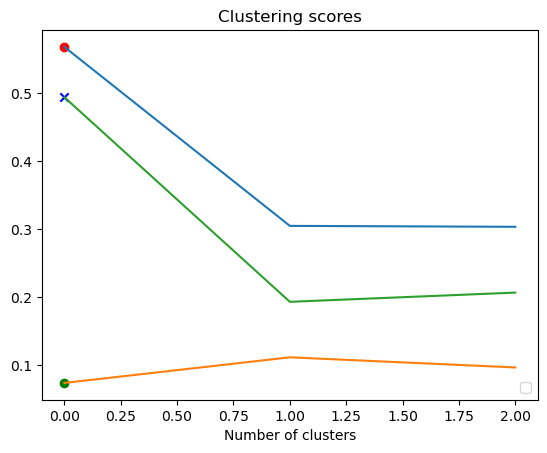



Best cluster in the range 2 to  4 is :  2 , with a silhouette score of:  0.568160679839749   


firing rate threshold:  0


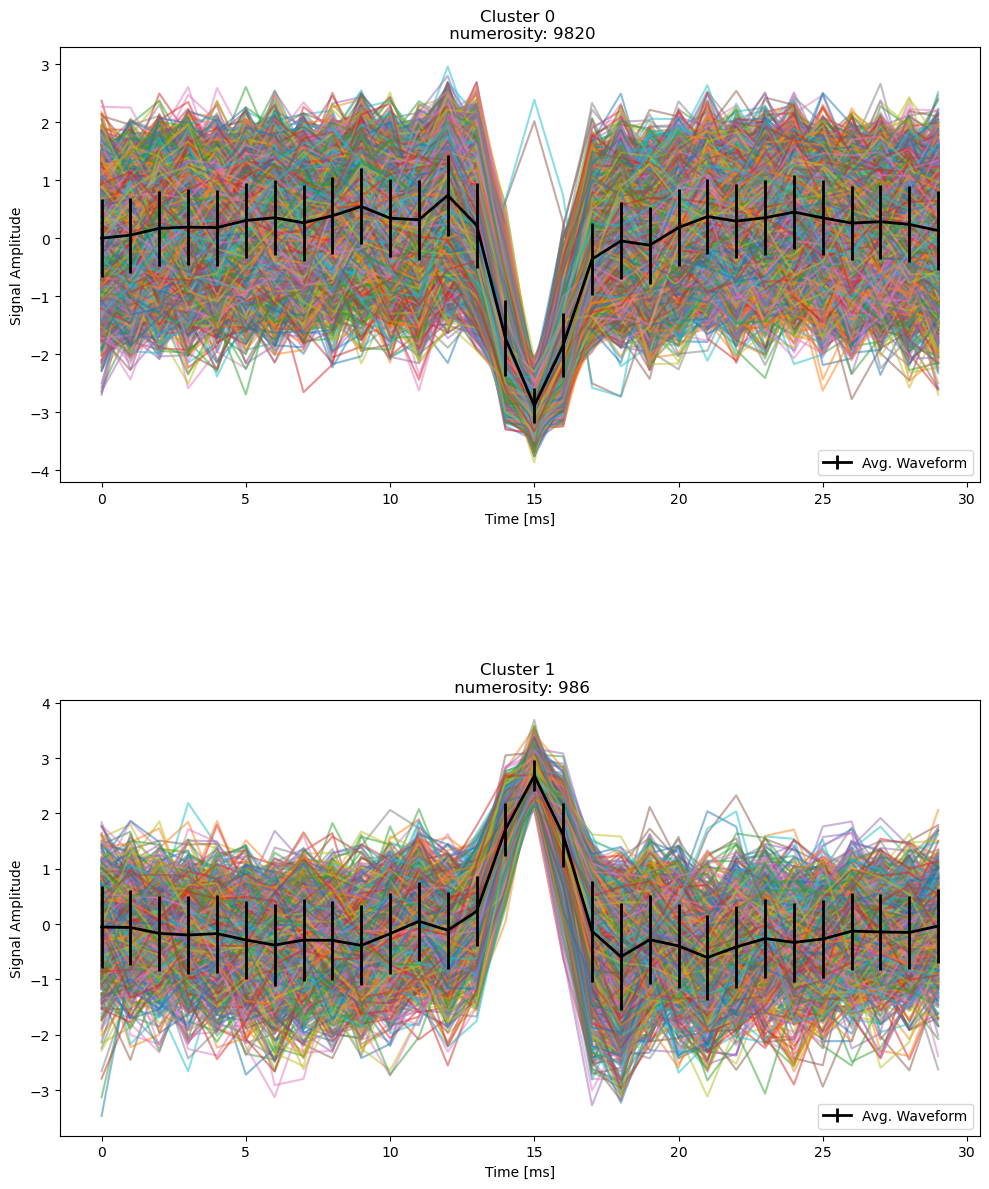

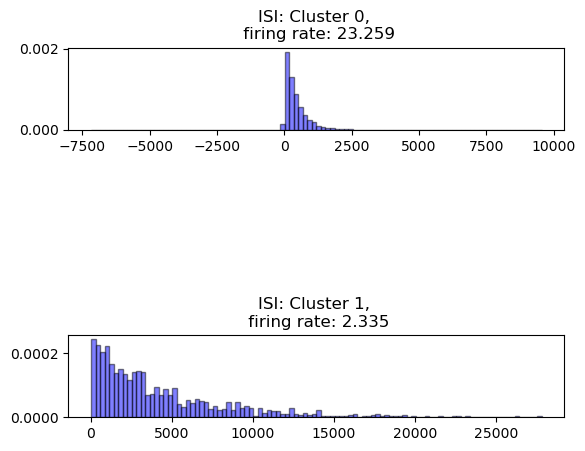

In [21]:
#final_data_pos= nested_clus(pos_cut,'fuzzy',n_pos,prova)
n_min=2
n_max=5
n_comp=3
final_data_pos= bounded_clus(n_comp,n_min,n_max,cut,'kmeans',alls,prova)

• distance tra indici detettati pari a lunghezza spike
• poi clustering con range dda 2 a 3 e se silhouette sotto una soglia è un cluster solo

In [ ]:
len(final_data_pos)

BL (window 3000, thresh 4) (less function) fuzzy (1.8, 4, 3.99)   
BL (window 300) (less function) fuzzy (19, 18, 9)   
BL (window 300) (less function) dbscan (30, 9)   
BL (window 300) (bit less function std) fuzzy (8.9, 18.2, 17.8)   
BL (window 300) (more cut function) fuzzy (8.9, 17.7, 18.3)   
BL (window 300) (more cut function) dbscan (29, 6)   
BL (less cut function) fuzzy: (15, 8 ,15)   

KA (window 300, thresh 4) (less function) fuzzy (3.8, 4, 1.9)   
KA (window 3000, thresh 4) (less function) fuzzy (2.6, 1.2, 2.8)   
KA stimualtion 3 clusters fuzzy: (13, 6, 12)   
KA stim (window 300) (new cut function) (1.17,2.55,2.37)   


#final_data_neg= nested_clus(neg_cut,'fuzzy',n_neg,prova)
n_min=2
n_max=5
n_comp=3
final_data_neg= bounded_clus(n_comp,n_min,n_max,neg_cut,'kmeans',n_neg,prova)

len(final_data_neg)

BL (less cut function) (window 3000, thresh4) fuzzy: (3.5, 3.5, 1.6) silhouette: 0.231    
BL (less cut function) (window 300) fuzzy: (17, 15, 6) silhouette: 0.215    
BL (more cut function) (window 300) fuzzy: (15, 16, 7) silhouette: 0.218    
BL (less cut function) fuzzy: (13, 13, 6) silhouette: 0.226    

KA (less cut function) (window 300, thresh4) fuzzy: (1.9, 1.12, 1.9) silhouette: 0.229   
KA (less cut function) (window 3000, thresh4) fuzzy: (1.4, 0.89, 1.4) silhouette: 0.223    
KA stimulation 3 clusters fuzzy: (3.9, 3.7, 2) silhouette: 0.214    
KA stimulation (more cut function) (window 3000) fuzzy: (2, 3.9, 3.7) silhouette: 0.214    
KA stimulation (more cut function) (window 300) fuzzy (4.5, 4.4, 2.2) silhouette: 0.204    
KA stimulation (more cut function) (window 300) dbscan (10.8,10.8)    

neurons=[]
final_data=final_data_pos
for arr in final_data:
    if len(arr)<30:
        for el in arr:
            neurons.append(el)
    else:
        neurons.append(arr)
final_data=final_data_neg
for arr in final_data:
    if len(arr)<5:
        for el in arr:
            neurons.append(el)
    else:
        neurons.append(arr)
print('len',len(neurons))

In [11]:
neurons = []
for neuron in final_data_pos:
    neurons.append(neuron)
len(neurons)

2

neur:  0 9870


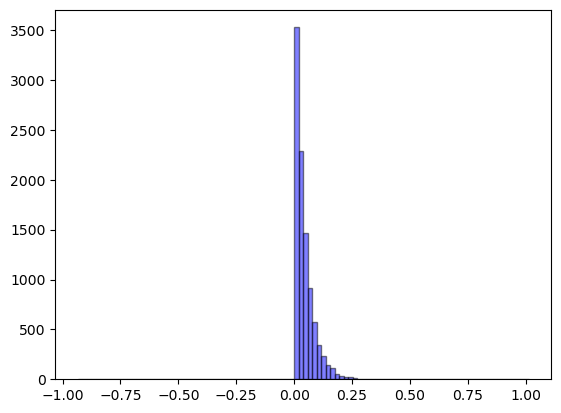

neur:  1 27012


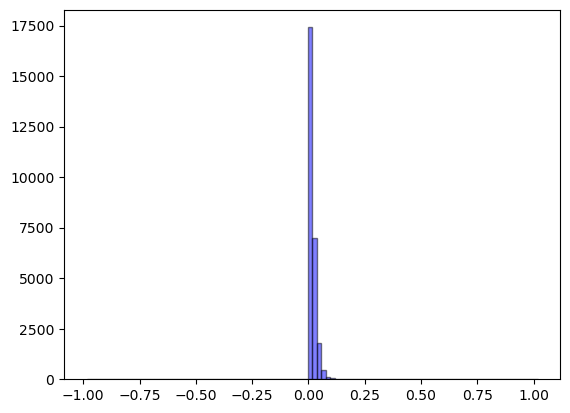

In [17]:
#x=randint(0,len(neurons)-1)
for x in range(0,len(neurons)):
    print('neur: ',x,len(neurons[x]))
    data_healthy=neurons[x]
    ISI_healthy = np.diff(data_healthy)/10000
    plt.hist(ISI_healthy, bins=100, density=False, alpha=0.5, color='blue', edgecolor='black')
    plt.show()

In [ ]:
data_healthy
ISI_healthy

In [ ]:
adj_neur=[]
counter = 0
max_len=0

for neu in neurons:
    print('counter: ',counter,neu.shape[0])
    if neu.shape[0]>max_len:
        max_len=neu.shape[0]
    counter+=1
for neuron in neurons:
    if neuron.shape[0]<=max_len:
        diff = max_len-neuron.shape[0]
        adj_neur.append(np.concatenate((neuron,np.zeros([diff]))))


In [ ]:
x=randint(0,len(adj_neur)-1)
print('neur: ',x)
data_healthy=adj_neur[x]
ISI_healthy = np.diff(data_healthy)/10000

In [ ]:
locs_diff=np.diff(data_healthy)
#plt.axis([-3,500,0,0.05])
plt.hist(locs_diff, bins=50, density=False, alpha=0.5, color='blue', edgecolor='black')

## Point Process

In [ ]:
ISI_data=ISI_healthy

In [ ]:
map_estimate,ppc_trace= Bayesian_mixture_model(ISI_healthy)

In [ ]:
#with model:
#    ppc_trace = pm.sample_posterior_predictive(trace,model=model)

bins = np.arange(0, .5, 1e-3) 
plt.figure (figsize=(14,10))

hist = np.histogram(ppc_trace['posterior_predictive']['like'].values,bins=bins)
#plt.axis([-0.01,0.13,0,160])
a= plt.hist(ISI_healthy,bins)
plt.plot(hist[1][:-1],hist[0]/1000,linewidth=3);

In [ ]:
lista_samples=[]
for i in list(ppc_trace['posterior_predictive']['like'].values):
    lista_samples.extend(i)

In [ ]:
counts, _ = np.histogram(ISI_healthy, bins) 
prob_emp = counts / np.sum(counts)
counts, _ = np.histogram(lista_samples, bins) 
prob_model = counts / np.sum(counts)

Femp = np.cumsum(prob_emp)           
Fmodel = np.cumsum(prob_model)          
plt.figure()
plt.plot(bins[:-1], Femp)                
plt.plot(bins[:-1], Fmodel, 'r')       
#plt.xlim([0, 0.2])                  
plt.xlabel('Time [s]')
plt.ylabel('CDF')
plt.legend(['Empirical','Model'])
plt.show()

In [ ]:
plt.figure()
Nlow = len(ISI_healthy)  
# Plot the confidence bounds
plt.plot([0, 1], [x + 1.36 / np.sqrt(Nlow) for x in [0, 1]], 'r:')
plt.plot([0, 1], [x - 1.36 / np.sqrt(Nlow) for x in [0, 1]], 'r:')
plt.plot(Femp, Fmodel)
#plt.axis([0, 1, 0, 1])         
plt.xlabel('Model CDF')
plt.ylabel('Empirical CDF')
plt.show()

In [ ]:
#plt.plot(Femp)
#plt.plot(Fmodel)
plt.plot(Femp,Fmodel)

In [ ]:
map_estimate = pm.find_MAP(model=model)
del map_estimate['w_simplex__']
del map_estimate['mu1_interval__']
del map_estimate['lam1_interval__']
del map_estimate['mu2_interval__']
del map_estimate['sigma2_interval__']
del map_estimate['mu3_interval__']
del map_estimate['sigma3_interval__']

map_estimate['w1'] = map_estimate['w'][0]
map_estimate['w2'] = map_estimate['w'][1]
map_estimate['w3'] = map_estimate['w'][2]

del map_estimate['w']


map_estimate

In [ ]:
dataframe = pd.DataFrame()
list_neurons = adj_neur
counter=0
print('Original number of neurons: ',len(list_neurons))
for neuron in list_neurons:
    neuron=neuron[neuron>0*10000]
    neuron=neuron[neuron<200*10000]
    print('  Neuron with ',neuron.shape[0],'spikes')
    if neuron.shape[0]>1000:

        counter+=1
    else:
        print('    Excluded neuron with n spikes = ',neuron.shape[0])
        continue

    ISI_healthy = np.diff(neuron)/10000


    map_estimate = Bayesian_mixture_model(ISI_healthy)

    df = pd.DataFrame.from_dict(map_estimate,orient='index')
    dataframe = pd.concat([dataframe,df],axis = 1)
print('Final number of neurons: ',counter)
print('Target = ',target)

In [ ]:
final = dataframe.T
final.to_csv('Data after PP/DataAfter')

## Classification

In [ ]:
def performance_visualizer(trials_obj,n_models,choice=False,**choice_var):
    
    import pandas as pd
    
    performance = [1-t['result']['loss'] for t in trials_obj.trials]
    
    
    hyperparam= list(trials_obj.trials[0]['misc']['vals'].keys())
    
    values_dict ={}
    
    for i in hyperparam:
        
        values_dict[i]=[]
        
        for j in trials_obj.trials:
            
            if(len(j['misc']['vals'][i])==0):
                
                values_dict[i].append(np.NaN)
                
            else:
            
                values_dict[i].append(j['misc']['vals'][i][0])
                
    out = pd.DataFrame.from_dict(values_dict)
    
    out['performance'] = performance
    
    out=out.sort_values(by=['performance'])
    
    
    if choice:
        
        for i in list(choice_var.keys()):
        
            for j,_ in enumerate(choice_var[i]):
        
                out[i]=out[i].replace(j,choice_var[i][j])
    
    return out.tail(n_models)

In [ ]:
dataset = pd.read_csv('Data after PP/Data')
dataset = dataset.drop(['Unnamed: 0'],axis=1)
dataset